# Google Trends Time Series Analysis of Concussions, Football, and the NFL

Resource Link: https://www.datasciencecentral.com/profiles/blogs/tutorial-forecasting-with-seasonal-arima

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 

link = "https://gothamcityesq.com/wp-content/uploads/2017/05/NFL-Helmet-To-Helmet-Hit-Image-via-Industry-Tap.jpg"
image1 = Image(url=link, width=1000)
display(image1)

### Introduction: 
With the discovered link between football and CTE (Chronic Traumatic Encephalopathy), I wanted to investigate search term correlation between the NFL and concussions. In particular, I wanted to see if there is a greater correlation between the NFL and concussions than football and concussions. I chose to search concussions instead of CTE because CTE can only be diagonosed post-morterm. Concussions are reported almost immediately and there are a lot more instances to work with.

The four search terms I collected data on are...
1. **"NFL"**
2. **"Football"**
3. **"Concussions"**
4. **"Concussion" under the injury topic**

(Google Trends allows one to specify a search term and a topic)

### Objectives:

The three main objectives of this report are to...
1. Find the correlations with the "NFL" and "Football" search terms
2. Determine if "NFL" has a stronger correlation to concussions than "Football"
3. Forecast relative search term interest 18 months into the future

#### Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import copy
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from matplotlib.lines import Line2D
from matplotlib import gridspec
warnings.filterwarnings('ignore')
sns.set()
%matplotlib inline

c:\users\mikes\appdata\local\programs\python\python36\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


#### Importing Data

In [3]:
#Reading in the nfl data
nfl = pd.read_excel('nfl_trends.xlsx').set_index('Month')
#Reading in football data
foot = pd.read_excel('football_trends.xlsx').set_index('Month')
#Reading in the concussion data
conc = pd.read_excel('concussion_trends.xlsx').set_index('Month')
#Reading in concussion injury data
inj = pd.read_excel('conc_injury.xlsx').set_index('Month')

#Combining the nfl and concussion dataframes
df = pd.merge(nfl, foot, left_index=True, right_index=True, suffixes=['_nfl', '_foot'])
df = pd.merge(df, conc, left_index=True, right_index=True)
df = pd.merge(df, inj, left_index=True, right_index=True, suffixes=['_concussion', '_inj'])

#Renaming the dataframes
df.rename(columns = {'Relative_Search_Interest_nfl':'NFL', 
                     'Relative_Search_Interest_concussion': 'Concussions',
                     'Relative_Search_Interest_foot': 'Football',
                    'Relative_Search_Interest_inj': 'Concussion (Injury)'}, inplace=True)

#Turning the date to index
df.index = pd.to_datetime(df.index)

# Data Exploration

Let's use visuals to inspect the relative frequency of searches for each search term. 

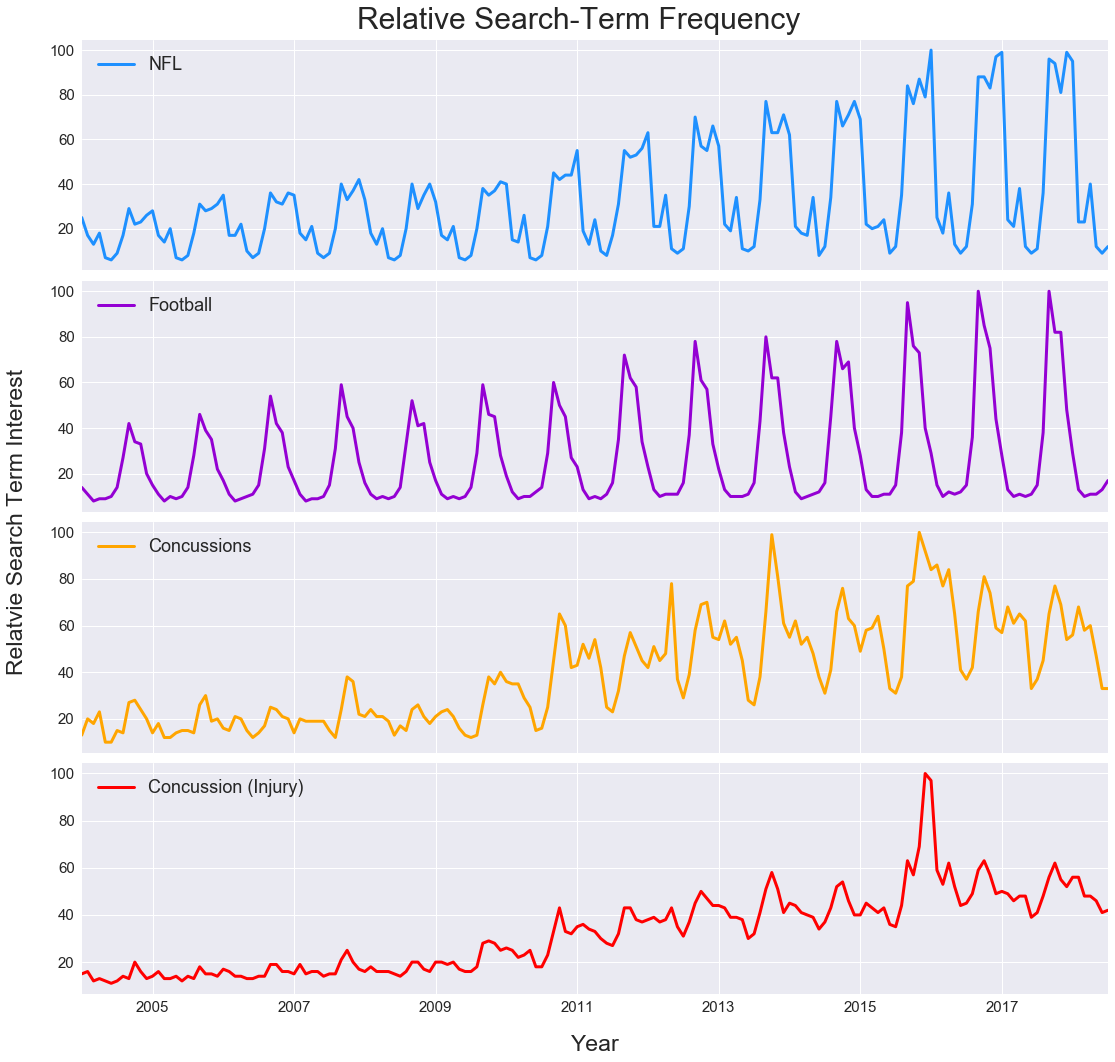

In [4]:
#Setting up the subplots
fig, axarr = plt.subplots(4, sharex=True)

#Plotting the 4 search terms
df['NFL'].plot(figsize=(12, 10), fontsize=15, linewidth=3, ax=axarr[0], color='dodgerblue')
df['Football'].plot(figsize=(15, 15), fontsize=15, linewidth=3, ax=axarr[1], color='darkviolet')
df['Concussions'].plot(figsize=(15, 15), fontsize=15, linewidth=3, ax=axarr[2], color='orange')
df['Concussion (Injury)'].plot(figsize=(15, 15), fontsize=15, linewidth=3, ax=axarr[3], color='red')
plt.xlabel('Year', fontsize=23, labelpad=20)
fig.text(-0.02, .63, 'Relatvie Search Term Interest', size=23, ha='center', rotation='vertical')
[ax.legend(prop={'size':18}, loc=2) for ax in axarr]
fig.suptitle('Relative Search-Term Frequency', size=30)
fig.tight_layout()
fig.subplots_adjust(top=.95);

From the above plot one can see that all four terms exhibit a positive trend over time, meaning interest in each term increased. "Football" appears to show the clearest seasonal trend, although "NFL" shows a strong seasonal trend as well. Interest in both concussion terms appears to spike in late 2015-early 2016. This is explained by the release of the movie "Concussion" starring Will Smith on December 25th, 2015. 

### Rolling Averages

Rolling averages find the mean of 'x' consecutive past data points to provide a smoothed out view of the data over time. It is a lagging indicator, and can be modified to include weights so that one can bias more recent points.

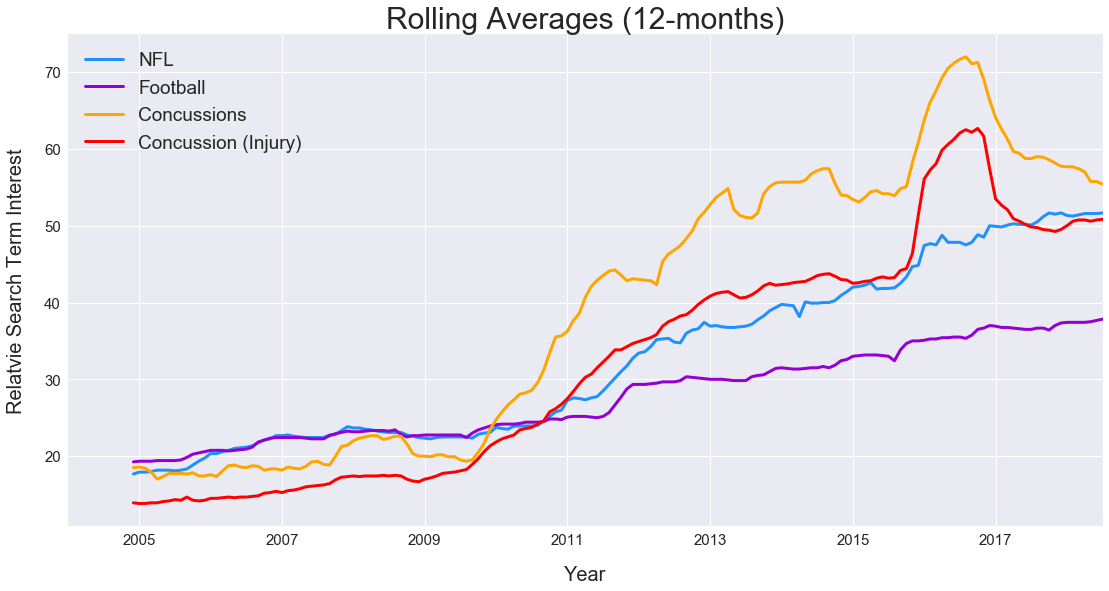

In [5]:
colors = ['dodgerblue', 'darkviolet', 'orange', 'red']
fig, ax = plt.subplots()
for col, color_spec in zip(df.columns, colors):
    df[col].rolling(12).mean().plot(figsize=(15, 8), fontsize=15, linewidth=3,color=color_spec, ax=ax)
plt.title('Rolling Averages (12-months)', size=30)
fig.tight_layout()
plt.xlabel('Year', fontsize=20, labelpad=18)
plt.ylabel('Relatvie Search Term Interest', size=20, labelpad=18)
plt.legend(loc=2, prop={'size':19});

While "Football" shows a relatively steady increase over time, the "concussions" and "concussion (injury)" terms show a sharp increase over time starting in around 2010, culminating with a peak in late 2015-early 2016 as described earlier. The "NFL" term has a large increase between 2011 and 2012, then settles into a more relaxed linear growth trend.

### Biggest Increase And Decrease in Relative Search-Term Frequency

#### "NFL" Trends

In [6]:
df.diff().groupby(df.index.year).agg({"NFL": ["idxmax", "max", "idxmin", "min"]}).loc[:2017]

NFL                       
          idxmax   max     idxmin   min
Month                                  
2004  2004-09-01  12.0 2004-05-01 -11.0
2005  2005-09-01  13.0 2005-05-01 -13.0
2006  2006-09-01  16.0 2006-02-01 -18.0
2007  2007-09-01  20.0 2007-02-01 -17.0
2008  2008-09-01  20.0 2008-02-01 -15.0
2009  2009-09-01  18.0 2009-02-01 -15.0
2010  2010-09-01  24.0 2010-02-01 -25.0
2011  2011-09-01  24.0 2011-02-01 -36.0
2012  2012-09-01  40.0 2012-02-01 -42.0
2013  2013-09-01  44.0 2013-02-01 -35.0
2014  2014-09-01  43.0 2014-02-01 -41.0
2015  2015-09-01  49.0 2015-02-01 -47.0
2016  2016-09-01  57.0 2016-02-01 -75.0
2017  2017-09-01  60.0 2017-02-01 -75.0

The results of the above table query make a whole lot of sense. Football season starts in early september, and as such that is when search interest in the NFL spikes. Conversely, search interest has suffered the biggest drop during Febuary for the last 12 years. Again, this makes sense, as the playoffs are in January, the Superbowl occurs the first week of Febuary, and then the season is over. 

#### "Football" Trends

In [7]:
df.diff().groupby(df.index.year).agg({"Football": ["idxmax", "max", "idxmin", "min"]}).loc[:2017]

Football                       
          idxmax   max     idxmin   min
Month                                  
2004  2004-09-01  15.0 2004-12-01 -13.0
2005  2005-09-01  18.0 2005-12-01 -13.0
2006  2006-09-01  23.0 2006-12-01 -15.0
2007  2007-09-01  28.0 2007-12-01 -15.0
2008  2008-08-01  19.0 2008-12-01 -17.0
2009  2009-09-01  30.0 2009-12-01 -17.0
2010  2010-09-01  31.0 2010-12-01 -18.0
2011  2011-09-01  37.0 2011-12-01 -24.0
2012  2012-09-01  41.0 2012-12-01 -24.0
2013  2013-09-01  37.0 2013-12-01 -24.0
2014  2014-09-01  33.0 2014-12-01 -29.0
2015  2015-09-01  57.0 2015-12-01 -33.0
2016  2016-09-01  64.0 2016-12-01 -31.0
2017  2017-09-01  62.0 2017-12-01 -34.0

Football mirrors the same trends as the NFL in terms of when search interest shows a drastic uptick. 13 of the 14 largest search term increases occur in September, with the other occuring the month before. Unlike "NFL", search interest decreases sharply in December, possibly corresponding to the end of high-school and college football seasons. 

#### "Concussions" Trends

In [8]:
df.diff().groupby(df.index.year).agg({"Concussions": ["idxmax", "max", "idxmin", "min"]}).loc[:2017]

Concussions                       
           idxmax   max     idxmin   min
Month                                   
2004   2004-09-01  13.0 2004-05-01 -13.0
2005   2005-09-01  12.0 2005-11-01 -11.0
2006   2006-09-01   8.0 2006-05-01  -5.0
2007   2007-10-01  14.0 2007-12-01 -14.0
2008   2008-09-01   9.0 2008-06-01  -6.0
2009   2009-09-01  13.0 2009-05-01  -5.0
2010   2010-09-01  20.0 2010-12-01 -18.0
2011   2011-09-01  15.0 2011-06-01 -17.0
2012   2012-05-01  30.0 2012-06-01 -41.0
2013   2013-10-01  33.0 2013-12-01 -20.0
2014   2014-09-01  25.0 2014-11-01 -13.0
2015   2015-09-01  39.0 2015-06-01 -17.0
2016   2016-09-01  24.0 2016-06-01 -24.0
2017   2017-09-01  20.0 2017-06-01 -29.0

13 of the 14 biggest increases in "concussions" search term interest occurs during the first two months of football season, with one outlier being May of 2012. June and December are when search term interest drops the most (9 out of 14 years), perhaps corresponding with students getting out of school.

#### "Concussion" (Injury) Trends

In [9]:
df.diff().groupby(df.index.year).agg({"Concussion (Injury)": ["idxmax", "max", "idxmin", "min"]}).loc[:2017]

Concussion (Injury)                       
                   idxmax   max     idxmin   min
Month                                           
2004           2004-10-01   7.0 2004-03-01  -4.0
2005           2005-09-01   5.0 2005-03-01  -3.0
2006           2006-09-01   5.0 2006-11-01  -3.0
2007           2007-09-01   6.0 2007-11-01  -5.0
2008           2008-09-01   4.0 2008-11-01  -3.0
2009           2009-09-01  10.0 2009-05-01  -3.0
2010           2010-09-01  10.0 2010-11-01 -10.0
2011           2011-09-01  11.0 2011-11-01  -5.0
2012           2012-09-01   8.0 2012-06-01  -8.0
2013           2013-09-01  10.0 2013-12-01 -10.0
2014           2014-09-01   9.0 2014-11-01  -8.0
2015           2015-12-01  31.0 2015-06-01  -7.0
2016           2016-09-01  10.0 2016-02-01 -38.0
2017           2017-09-01   8.0 2017-06-01  -9.0

Other than the 2015 when concussion injury searches spiked in December, the biggest spike has come in September since 2005. The biggest decrease shows less consistency, with November exhibiting the most frequent largest decrease. 

## Converting Time Series From Non-Stationary To Stationary

In order to make predictions of any sort, we need each time series to be stationary. A stationary time series meets the following assumptions...
1. The mean is constant over time
2. The variance is constant over time (homoscedasticity)
3. The autocorrelation is constant over time

We can test stationarity with the Dickey Fuller test. This test determines whether or not there is a unit root present in the data, i.e. a trend causing one a violation of the above assumptions.

In order to meet these assumptions, we must remove both the seasonal and linear trends from our data. A log transformation should fix the variance issue, and first-order differencing should remove the linear trend.

### Fixing the Non-Constant Variance

In [10]:
#Log transformation dataframe
logged_df = np.log(df)

#Colormap dictionary
color_dict = dict({'NFL': 'dodgerblue', 'Football': 'darkviolet', 'Concussions': 'orange', 'Concussion (Injury)': 'red'})

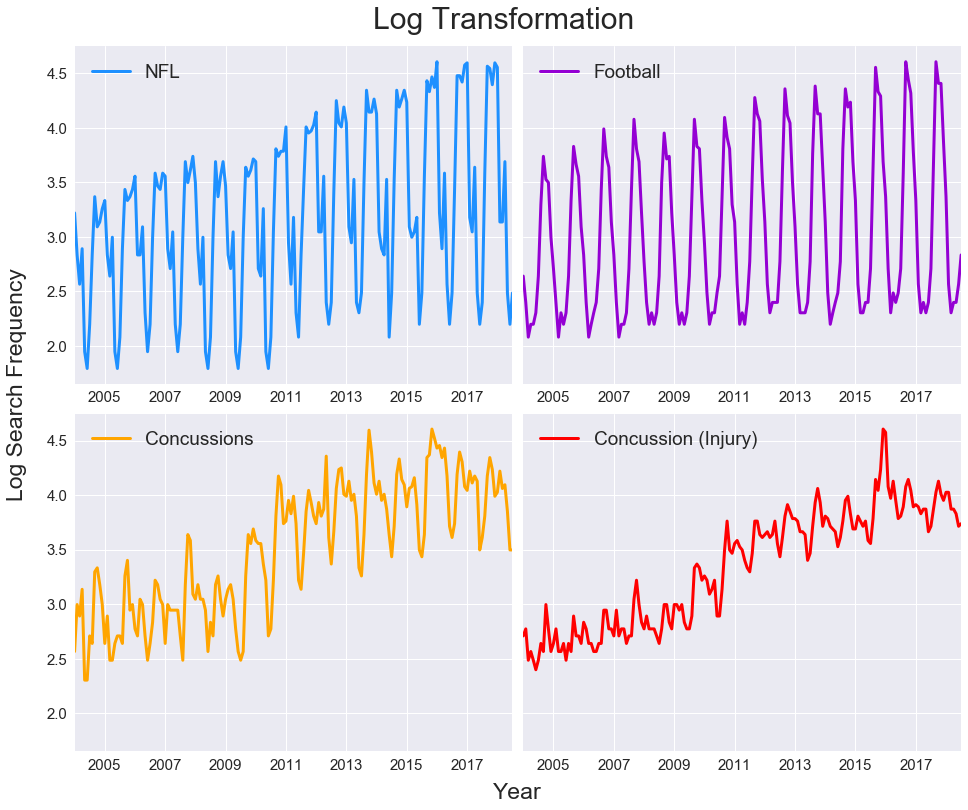

In [52]:
#Instantiating the plot
fig, axarr = plt.subplots(ncols=2, nrows=2, figsize=(13, 11), sharey=True)

#Plotting the 4 differenced terms
for col, axs in zip(logged_df.columns, axarr.flatten()):
    logged_df[col].plot(linewidth=3, ax=axs, color=color_dict[col])
    axs.tick_params(labelsize=15)

#Setting legends and xlabels
[ax.legend(prop={'size':19}, loc=2) for ax in axarr.flatten()]
[ax.set_xlabel('', size=18) for ax in axarr.flatten()]

#Labels and layout
fig.suptitle('Log Transformation', size=30)
fig.tight_layout()
fig.subplots_adjust(top=.93)
fig.text(-0.02, .63, 'Log Search Frequency', size=23, ha='center', rotation='vertical')
fig.text(.514, -0.02, 'Year', size=23, ha='center');

It appears that the variance is reasonably constant for each seasonal period over time. Later we will take care of this seasonal element, but for now let's move on to the fixing the linear trend.

### Removing the Positive Linear Trends

In [12]:
#Creating the differenced dataframe
log_diff_df = logged_df.diff(periods=1)

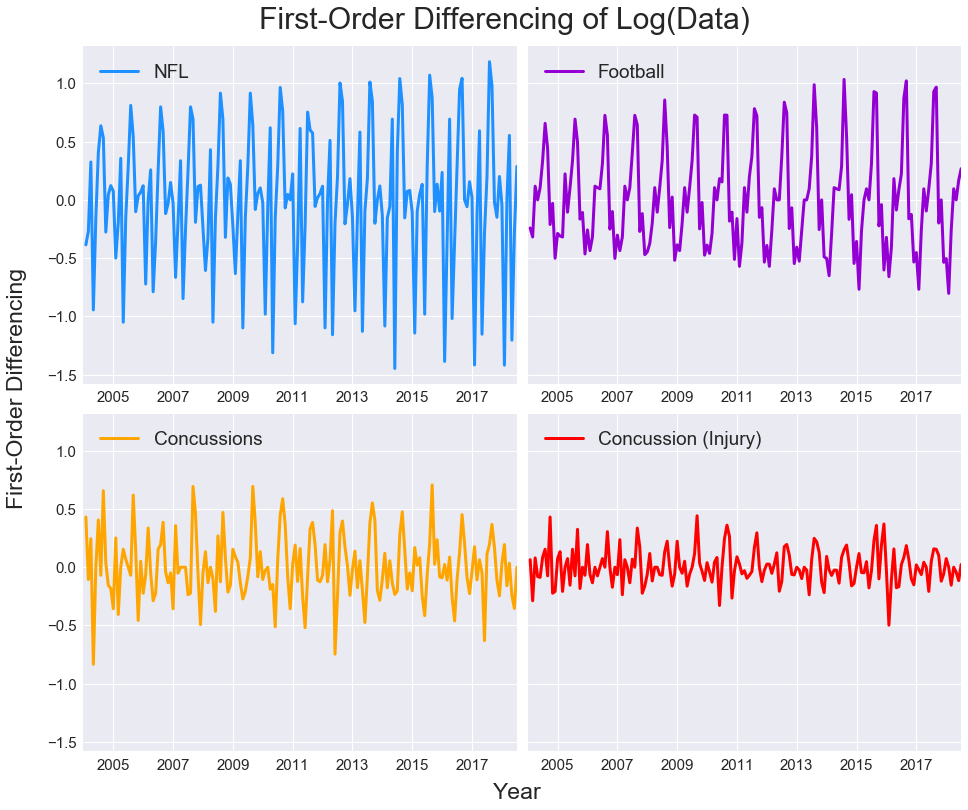

In [53]:
#Creating the figure
fig, axarr = plt.subplots(ncols=2, nrows=2, figsize=(13, 11), sharey=True)

#Colormap dictionary
color_dict = dict({'NFL': 'dodgerblue', 'Football': 'darkviolet', 'Concussions': 'orange', 'Concussion (Injury)': 'red'})

#Plotting the 4 differenced terms
for col, axs in zip(log_diff_df.columns, axarr.flatten()):
    log_diff_df[col].plot(linewidth=3, ax=axs, color=color_dict[col])
    axs.tick_params(labelsize=15)


#Setting legends and xlabels
[ax.legend(prop={'size':19}, loc=2) for ax in axarr.flatten()]
[ax.set_xlabel('', size=18) for ax in axarr.flatten()]

fig.suptitle('First-Order Differencing of Log(Data)', size=30)
fig.tight_layout()
fig.subplots_adjust(top=.93)
fig.text(-0.02, .63, 'First-Order Differencing', size=23, ha='center', rotation='vertical')
fig.text(.514, -0.02, 'Year', size=23, ha='center');

Awesome, the time series are looking a whole lot more stationary. The last thing we must address is the unstable seasonal trend in each term, which can be done using SARIMA (Seasonal Autoregressive Integrated Moving Average). Let's take a look at  the autocorrelation plots to confirm our time series are not random, and get an idea of where the significant lags are.

### Autocorrelation

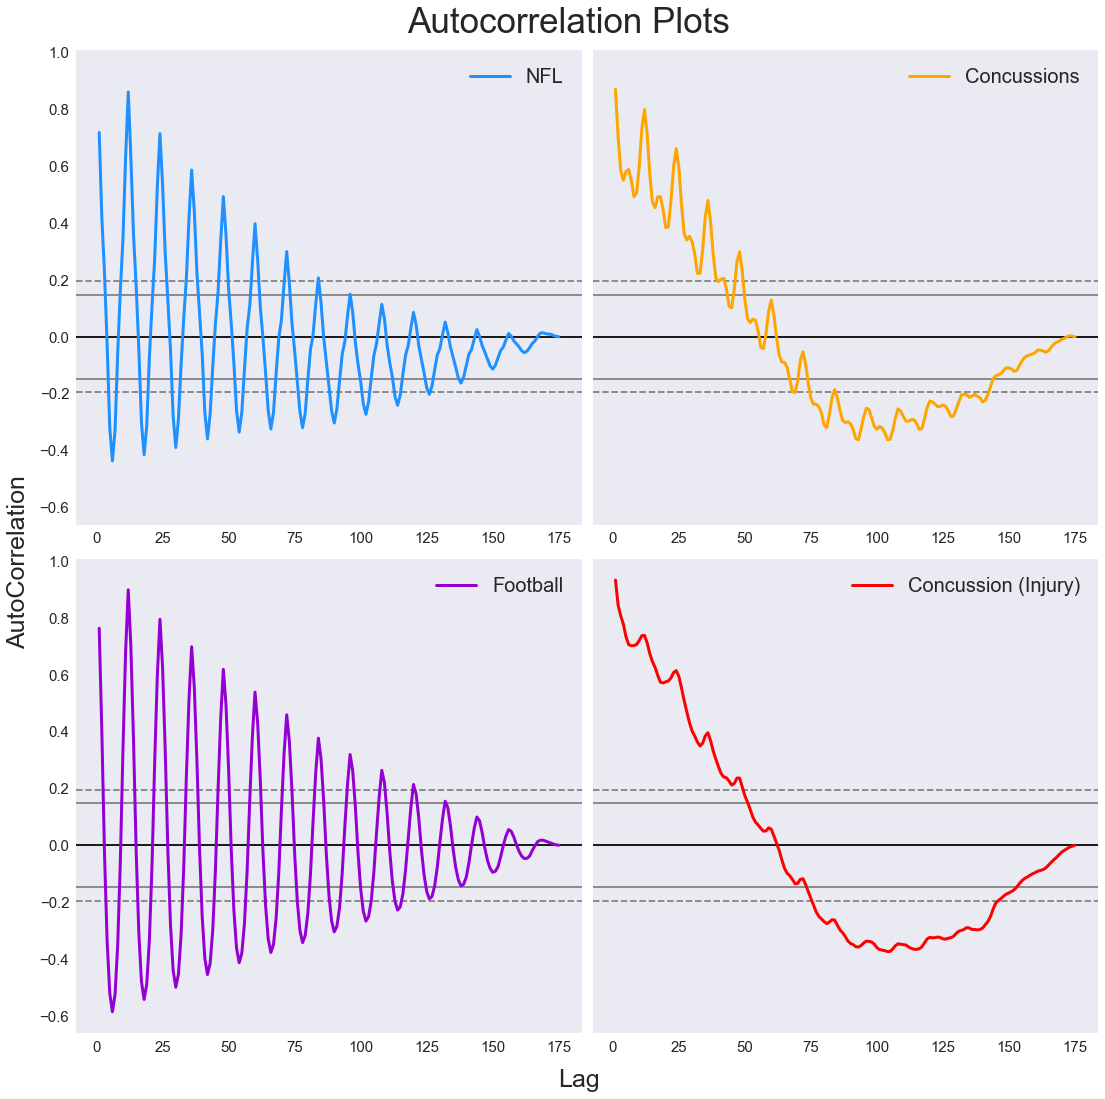

In [55]:
#Creating the figure
fig, axarr = plt.subplots(ncols=2, nrows=2, figsize=(15, 15), sharey=True)

#Plotting the 4 search terms
pd.plotting.autocorrelation_plot(df[['NFL']], color='dodgerblue', ax=axarr[0, 0], lw=3)
pd.plotting.autocorrelation_plot(df[['Football']], color='darkviolet', ax=axarr[1, 0], lw=3)
pd.plotting.autocorrelation_plot(df[['Concussions']], color='orange', ax=axarr[0, 1], lw=3)
pd.plotting.autocorrelation_plot(df[['Concussion (Injury)']], color='red', ax=axarr[1, 1], lw=3)

#Setting the x and y labels
[ax.set_xlabel('', size=18) for ax in axarr.flatten()]
[ax.set_ylabel('') for ax in axarr.flatten()]
[ax.tick_params(labelsize=15) for ax in axarr.flatten()]


#Setting the legends
axarr[0, 0].legend([Line2D([0], [0], color='dodgerblue', lw=3)], ['NFL'], prop={'size':20}, loc=1)
axarr[1, 0].legend([Line2D([0], [0], color='darkviolet', lw=3)], ['Football'], prop={'size':20}, loc=1)
axarr[0, 1].legend([Line2D([0], [0], color='orange', lw=3)], ['Concussions'], prop={'size':20}, loc=1)
axarr[1, 1].legend([Line2D([0], [0], color='red', lw=3)], ['Concussion (Injury)'], prop={'size':20}, loc=1)

#Setting the title and label locations
fig.suptitle('Autocorrelation Plots', size=35)
fig.tight_layout()
fig.subplots_adjust(top=.94)
fig.text(.49, -0.02, 'Lag', size=25)
fig.text(-.02, 0.53, 'AutoCorrelation', size=25, rotation='vertical');

In [15]:
print('NFL autocorrelation coefficient: ', np.round(df.NFL.autocorr(12), 3))
print('Football autocorrelation coefficient: ', np.round(df.Football.autocorr(12), 3))
print('Concussions autocorrelation coefficient: ', np.round(df.Concussions.autocorr(12), 3))
print('Concussion (Injury) autocorrelation coefficient: ', np.round(df['Concussion (Injury)'].autocorr(12), 3))

NFL autocorrelation coefficient:  0.978
Football autocorrelation coefficient:  0.992
Concussions autocorrelation coefficient:  0.863
Concussion (Injury) autocorrelation coefficient:  0.822


From the above plots and the corresponding autocorrelation calculations, we can see that the search term interest data for "NFL" and "Football" follows a 12 month cycle, mimicing the periodicity of a football season. "Concussions" and "Concussion" under the topic of injury have strong 12 month autocorrelation coefficients as well (.862 and .822 respectively). This gives reason to belive that concussion search interest follows an annual period as well.

### Dickey Fuller

Since the Dicky Fuller model has a lag feature built in, we are at a point where we can use it to test stationarity. 

In [16]:
cols = ['Test-Stat', 'p-value', 'lags', '#obs', '1%_crit_val', '5%_crit_val']
dicky_fuller = pd.DataFrame(index=[col for col in log_diff_df.columns], columns = cols)
for col in log_diff_df.columns:
    data = adfuller(log_diff_df[col].dropna(), maxlag=12, autolag=None)
    data_list = [i for i in data]
    data_list.append(data_list[4]['5%'])
    data_list[4] = data_list[4]['1%']
    dicky_fuller.loc[col] = data_list
dicky_fuller

,Test-Stat,p-value,lags,#obs,1%_crit_val,5%_crit_val
NFL,-7.11935,3.75769e-10,12,161,-3.47163,-2.87967
Football,-7.05451,5.41869e-10,12,161,-3.47163,-2.87967
Concussions,-5.2929,5.66429e-06,12,161,-3.47163,-2.87967
Concussion (Injury),-4.07827,0.00105179,12,161,-3.47163,-2.87967


With a built in lag of 12 (representing lag of 1 year), each search-term is significant at the 1% level. Thus, we can reject the null hypothesis that there is a unit root for serial correlation and conclude that over a 12 month interval there is no unit root. This means that for a 12 month lag, each search term is stationary.

# Term Correlation

Knowing that all 4 search terms follow an annual cycle to a significant extent, let's see if they are correlated like I hypothesized.  

In [17]:
corrDF = copy.copy(df)
corrDF['Concussions(-1)'] = corrDF.Concussions.shift(-1)
corrDF['Concussions(+1)'] = corrDF.Concussions.shift(1)
corrDF['Concussion (Injury)(-1)'] = corrDF['Concussion (Injury)'].shift(-1)
corrDF['Concussion (Injury)(+1)'] = corrDF['Concussion (Injury)'].shift(1)

In [18]:
corrDF = corrDF.dropna()
corrDF.corr()[['NFL', 'Football']]

,NFL,Football
NFL,1.000000,0.771899
Football,0.771899,1.000000
Concussions,0.637562,0.461315
Concussion (Injury),0.638002,0.428992
Concussions(-1),0.685858,0.552024
Concussions(+1),0.508815,0.226097
Concussion (Injury)(-1),0.617045,0.462658
Concussion (Injury)(+1),0.546552,0.302907


Before any annual trends are considered or removed, we can see that "NFL" and "Football" are strongly correlated, although not as strongly as I would have expected. Note that both "NFL" and "Football" correlate strongest with "Concussions" when it is lagged by 1. Before any transformations occur, "NFL" is significantly more correlated with both concussion search terms and their shifts. 

In [19]:
corrDF.diff().corr()[['NFL', 'Football']]

,NFL,Football
NFL,1.000000,0.606460
Football,0.606460,1.000000
Concussions,0.216051,0.424935
Concussion (Injury),0.420763,0.378679
Concussions(-1),0.468367,0.452672
Concussions(+1),0.013808,0.012838
Concussion (Injury)(-1),0.327167,0.313643
Concussion (Injury)(+1),0.027635,0.110104


When we remove the linear growth trend from the data, we see the correlations go down sharply for both "NFL" and "Football". NFL correlation with "Concussions" is approximately half of what it is for "Football". However when "Concussions" is lagged by 1, NFL and Football are about even. Other than the non-lagged "Concussions" term, "NFL" has slightly larger correlation values than "Football".

**What We've Learned:** In terms of overall correlation, the "NFL" search term is more strongly correlated with both concussion terms and their shifts. In terms of seasonal correlation, the "NFL" and "Football" search terms are about equivalent, except for the non-shifted "Concussions" term which sees "Football" doubling "NFL". 

# ACF + PACF Plots 

ACF and PACF plots show where the significant lags in the data are. ACF shows shows the correlation in data between two unique points of time (the original and the lag). PACF shows the same thing except with the contribution of the in between lags being removed as it is already accounted for.

In [20]:
lag_acf = acf(log_diff_df.NFL.dropna(), nlags=60)
lag_pacf = pacf(log_diff_df.NFL.dropna(), nlags=60, method='ols')

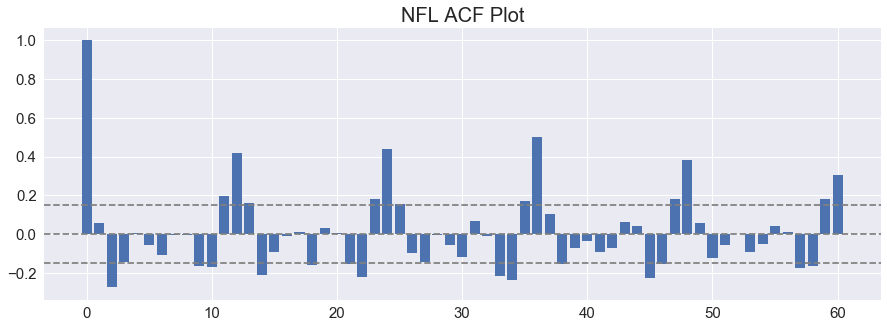

In [56]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.bar(np.arange(61), lag_acf)
plt.axhline(y=0, linestyle='--', color='grey')
plt.axhline(y=1.96/np.sqrt(len(log_diff_df.NFL.dropna())), linestyle='--', color='grey')
plt.axhline(y=-1.96/np.sqrt(len(log_diff_df.NFL.dropna())), linestyle='--', color='grey')
ax.tick_params(labelsize=15)
plt.title('NFL ACF Plot',size=20);

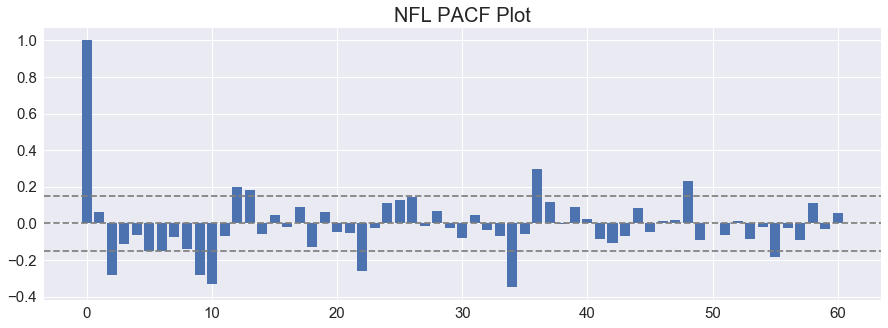

In [57]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.bar(np.arange(61), height=lag_pacf)
plt.axhline(y=0, linestyle='--', color='grey')
plt.axhline(y=1.96/np.sqrt(len(log_diff_df.NFL.dropna())), linestyle='--', color='grey')
plt.axhline(y=-1.96/np.sqrt(len(log_diff_df.NFL.dropna())), linestyle='--', color='grey')
ax.tick_params(labelsize=15)
plt.title('NFL PACF Plot', size=20);

**SARIMA EQUATION:** Rather than re-invent the wheel, please take a look at the provided resource at the top of this notebook to see the SARIMA equation. The next paragraph references the terms of the equation, with values coming from the plots. Explanation for value selection can be found in the document as well.

From the acf plot, we see the first significant lag value is 2, thus q = 2. The same can be said for the PACF plot, thus p = 2. Since we differenced the data, d = 1. With a big value at lag = 12, we know that our seasonal value S = 12, and because it is positive we know P = 1, and Q = 0.  Since the Seasonal pattern is not stable, D = 0.

# Building SARIMA Model

To build our SARIMA model, we first need to separate our data into train and test so we can validate our results with Root Mean Squared Error. To build the model, we will use the log(data) as SARIMA has a built in parameter for differencing. This will allow us to use grid search methodology later so we can confirm our parameters are optimal.

In [23]:
#Train and Test data
split_idx = round(logged_df.shape[0] * .75)
train = logged_df[:split_idx]
test = logged_df[split_idx:]

In [24]:
def sarima_fxn(input_data, arima_order_list, s_order_list, train, test, col):
    """Helper function using the SARIMA stats model. Builds the model using input train and test,
    forecasts, and outputs the important data."""
    a =  arima_order_list
    s = s_order_list
    
    #Instantiating and Fitting the SARIMA model
    model = SARIMAX(train[col], order=(a[0], a[1], a[2]), seasonal_order=(s[0], s[1], s[2], s[3]), enforce_stationarity=False,
               enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    
    #Forecasting/Predicting the test data
    forecast = model_fit.forecast(test.shape[0])
    forecast = np.exp(forecast)
    
    #Calculating the Root-Mean-Squared Error
    rmse = np.sqrt(sum((forecast-test[col])**2/test[col].shape[0]))
    
    #Output fitted on the train data by the model
    ref = np.exp(model_fit.fittedvalues)
    
    #Adding the last fitted value to the series of forecasted values (need value and timestamp)
    tstamp = ref.index[-1]
    tvalue = ref[-1]
    first_point = pd.Series(tvalue, index=[tstamp])
    forecast = pd.concat([first_point, forecast])
    
    return(forecast, ref, rmse)

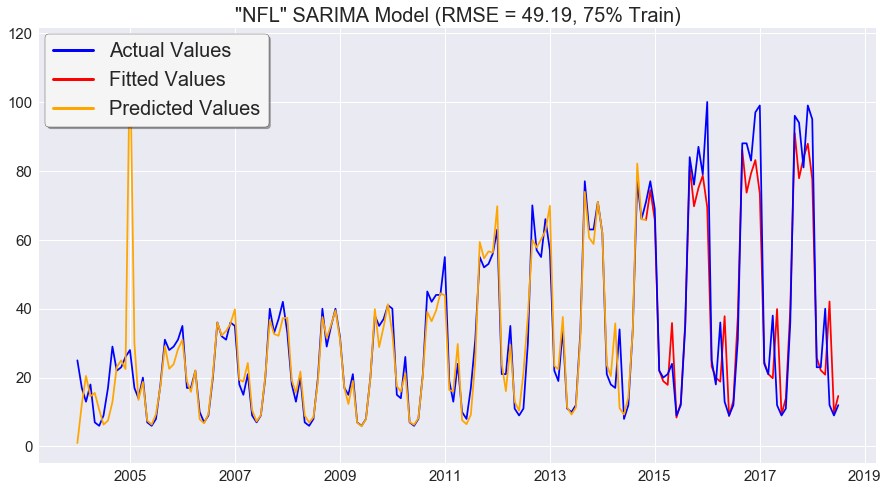

In [58]:
#SARIMA Helper Function usage
forecast, ref, rmse = sarima_fxn(logged_df, [2, 1, 2], [1, 0, 0, 12], train, test, 'NFL')

#Plotting The Outputs
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(forecast, 'r')
ax.plot(df.NFL, 'b')
ax.plot(ref, 'orange')
ax.set_title('"NFL" SARIMA Model (RMSE = %.2f, 75%% Train)'% rmse, size=20)
ax.tick_params(labelsize=15)

#Custom Legend
custom_lines = [Line2D([0], [0], color='blue', lw=3),
                Line2D([0], [0], color='red', lw=3),
                Line2D([0], [0], color='orange', lw=3)]

ax.legend(custom_lines, ['Actual Values', 'Fitted Values', 'Predicted Values'], 
          loc=2, prop={'size':20}, fancybox=True, frameon=True,
          shadow=True, facecolor='whitesmoke', edgecolor='k',
          framealpha=1, borderaxespad=.3);

Other than the strange spike at the beginning of 2005, this model appears to fit the data rather well. Let's use grid search to see if we can improve upon this result.

### SARIMA Grid Search

In [26]:
cols = ['p-d-q', 'RMSE']
results_df = pd.DataFrame(columns=cols)
def Sarima_grid(search_term, train, test, max_p, max_d, max_q, df):
    #Instantiate model
    for p in range(max_p):
        for d in range(max_d):
            for q in range(max_q):   
                model = SARIMAX(train[search_term], order=(p, d, q), 
                            seasonal_order=(1, 0, 0, 12), enforce_stationarity=False,
                            enforce_invertibility=False)
                
                #Fit
                model_fit = model.fit(disp=False)
                
                #Forecast
                forecast = model_fit.forecast(test.shape[0])
                forecast = np.exp(forecast)
                
                #RMSE
                rmse = np.sqrt(sum((forecast-test[search_term])**2/test[search_term].shape[0]));
                
                df = df.append({'p-d-q': str(p)+'-'+str(d)+'-'+str(q), 'RMSE':rmse}, ignore_index=True)
    return(df)

In [27]:
out_df = Sarima_grid('NFL', train, test, 5, 2, 5, results_df)

#Finding p-d-q with lowest RMSE
out_df=out_df.set_index('p-d-q')
pd.DataFrame(out_df.loc[out_df.idxmin()[0]]).transpose()

,RMSE
2-1-4,45.947689


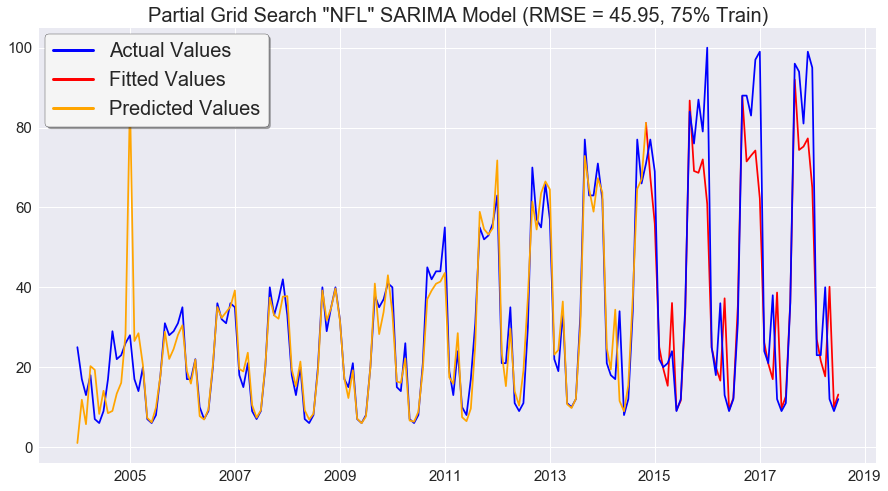

In [59]:
#SARIMA Helper Function usage
forecast, ref, rmse = sarima_fxn(logged_df, [2, 1, 4], [1, 0, 0, 12], train, test, 'NFL')

#Plotting The Outputs
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(forecast, 'r')
ax.plot(df.NFL, 'b')
ax.plot(ref, 'orange')
ax.set_title('Partial Grid Search "NFL" SARIMA Model (RMSE = %.2f, 75%% Train)'% rmse, size=20)
ax.tick_params(labelsize=15)

#Custom Legend
custom_lines = [Line2D([0], [0], color='blue', lw=3),
                Line2D([0], [0], color='red', lw=3),
                Line2D([0], [0], color='orange', lw=3)]

ax.legend(custom_lines, ['Actual Values', 'Fitted Values', 'Predicted Values'], 
          loc=2, prop={'size':20}, fancybox=True, frameon=True,
          shadow=True, facecolor='whitesmoke', edgecolor='k',
          framealpha=1, borderaxespad=.3);

There is minimal difference between the plots, however it should be noted that both struggle with the change in behavior from 2015-2018. It appears that the peak interest month changed over this period, and since these years are not in the training data, it cannot predict this.

### Seasonal Grid Search

In [30]:
cols = ['P-D-Q', 'RMSE']
seasonal_results_df = pd.DataFrame(columns=cols)
def seasonal_grid(search_term, train, test, max_P, max_D, max_Q, df):
    #Instantiate model
    for P in range(max_P):
        for D in range(max_D):
            for Q in range(max_Q):   
                model = SARIMAX(train[search_term], order=(2, 1, 4), 
                            seasonal_order=(P, D, Q, 12), enforce_stationarity=False,
                            enforce_invertibility=False)
                
                #Fit
                model_fit = model.fit(disp=False)
                
                #Forecast
                forecast = model_fit.forecast(test.shape[0])
                forecast = np.exp(forecast)
                
                #RMSE
                rmse = np.sqrt(sum((forecast-test[search_term])**2/test[search_term].shape[0]));
                
                df = df.append({'P-D-Q': str(P)+'-'+str(D)+'-'+str(Q), 'RMSE':rmse}, ignore_index=True)
    return(df)

In [33]:
out_df = seasonal_grid('NFL', train, test, 3, 3, 3, seasonal_results_df)

#Finding p-d-q with lowest RMSE
out_df=out_df.set_index('P-D-Q')
pd.DataFrame(out_df.loc[out_df.idxmin()[0]]).transpose()

,RMSE
0-0-1,28.268896


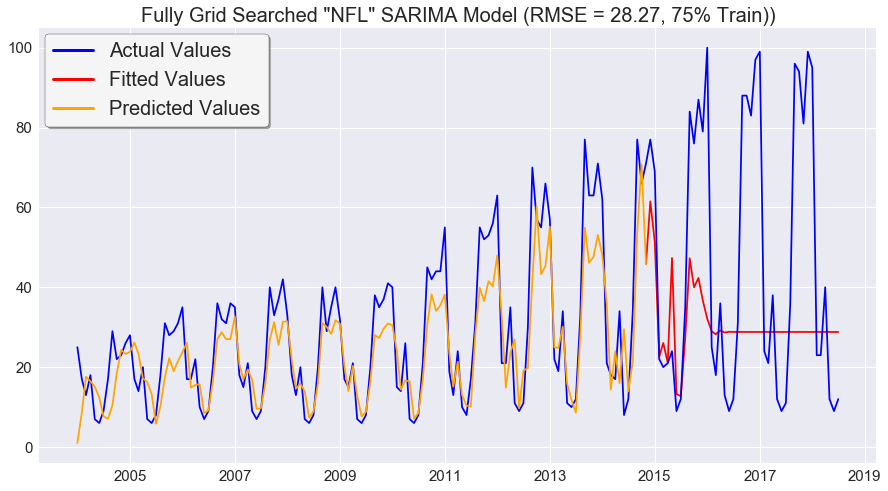

In [60]:
#SARIMA Helper Function usage
forecast, ref, rmse = sarima_fxn(logged_df, [2, 1, 4], [0, 0, 1, 12], train, test, 'NFL')

#Plotting The Outputs
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(forecast, 'r')
ax.plot(df.NFL, 'b')
ax.plot(ref, 'orange')
ax.set_title('Fully Grid Searched "NFL" SARIMA Model (RMSE = %.2f, 75%% Train))'% rmse, size=20)
ax.tick_params(labelsize=15)

#Custom Legend
custom_lines = [Line2D([0], [0], color='blue', lw=3),
                Line2D([0], [0], color='red', lw=3),
                Line2D([0], [0], color='orange', lw=3)]

ax.legend(custom_lines, ['Actual Values', 'Fitted Values', 'Predicted Values'], 
          loc=2, prop={'size':20}, fancybox=True, frameon=True,
          shadow=True, facecolor='whitesmoke', edgecolor='k',
          framealpha=1, borderaxespad=.3);

We can see that when trying to optimize the seasonal part of the ARIMA funciton, it is better to use visual intuition as opposed to only prioritizing RMSE. This model has little to no predictive value, and will be discarded immediately. 

# Forecasting

With the optimal SARIMA values in hand, we can now forecast into the future. There will be two models, one trained on 75% of the data, and one trained on 100%, with each forecasting 12 months into the future.

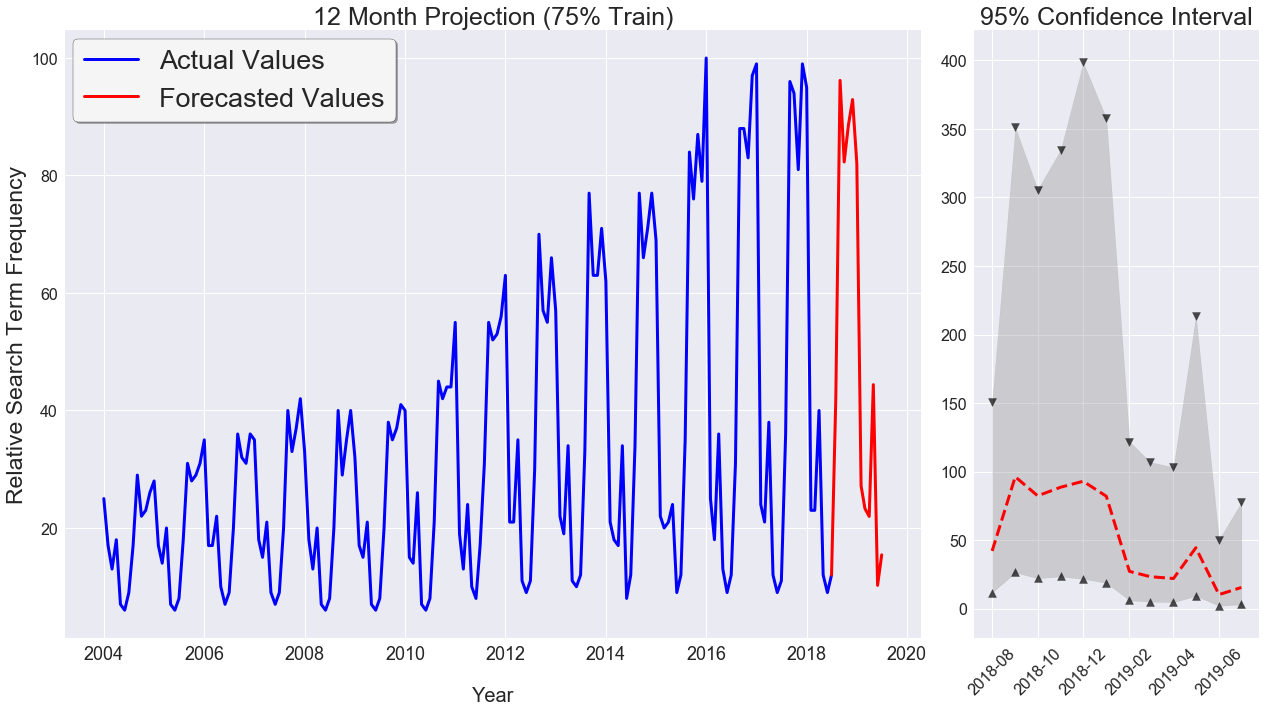

In [35]:
#Instantiating and fitting the model
model = SARIMAX(train.NFL, order=(2, 1, 2), seasonal_order=(1, 0, 0, 12), enforce_stationarity=False,
               enforce_invertibility=False)

model_fit = model.fit(disp=False)

#Forecasting the model
forecast = model_fit.forecast(test.shape[0]+12)
forecast = np.exp(forecast)
forecast = forecast[-12:]

#Finding the forecast confidence interval
predict = model_fit.get_prediction(end=model.nobs+test.shape[0]+11)
idx = forecast.index
predict_ci = predict.conf_int(alpha=.05)

#Forecasting from the last fitted model point (visual purposes)
tstamp = df.NFL.index[-1]
tvalue = df.NFL[-1]
first_val = pd.Series(tvalue, index=[tstamp])
forecast = pd.concat([first_val, forecast])

#Past data and forecast plot
fig, ax = plt.subplots(figsize=(18, 10))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
ax0 = plt.subplot(gs[0])
ax0.plot(df.NFL, 'b', lw=3)
ax0.plot(forecast, 'r', lw=3)
ax0.set_title('12 Month Projection (75% Train)', size=25)

#C.I. Plot
ax1 = plt.subplot(gs[1])
ax1.plot(forecast[1:], 'r', lw=3, linestyle='--')
ax1.fill_between(idx[-12:], np.exp(predict_ci.iloc[:, 0][-12:]), np.exp(predict_ci.iloc[:, 1][-12:]), alpha=.3, color='grey')
ax1.scatter(x=idx[-12:],y=np.exp(predict_ci.iloc[:, 0][-12:]), color='k', s=65, alpha=.7, marker='^')
ax1.scatter(x=idx[-12:],y=np.exp(predict_ci.iloc[:, 1][-12:]), color='k', s=65, alpha=.7, marker='v')
ax1.set_title('95% Confidence Interval', size=25)

#Setting tick size for plot 1
[xtick.set_fontsize(18) for xtick in ax0.get_xticklabels()]
[ytick.set_fontsize(16) for ytick in ax0.get_yticklabels()]

#Setting tick size and rotation for plot 2
[xtick.set_fontsize(16) for xtick in ax1.get_xticklabels()]
[xtick.set_rotation(45) for xtick in ax1.get_xticklabels()]
[ytick.set_fontsize(16) for ytick in ax1.get_yticklabels()]

#Setting x and y labels
ax0.set_ylabel('Relative Search Term Frequency', size=23)
ax0.set_xlabel('Year', size=20, labelpad=23)

#Custom Legend
custom_lines = [Line2D([0], [0], color='blue', lw=3),
                Line2D([0], [0], color='red', lw=3)]

ax0.legend(custom_lines, ['Actual Values', 'Forecasted Values'], 
          loc=2, prop={'size':27}, fancybox=True, frameon=True,
          shadow=True, facecolor='whitesmoke', edgecolor='k',
          framealpha=1, borderaxespad=.3)

fig.tight_layout();

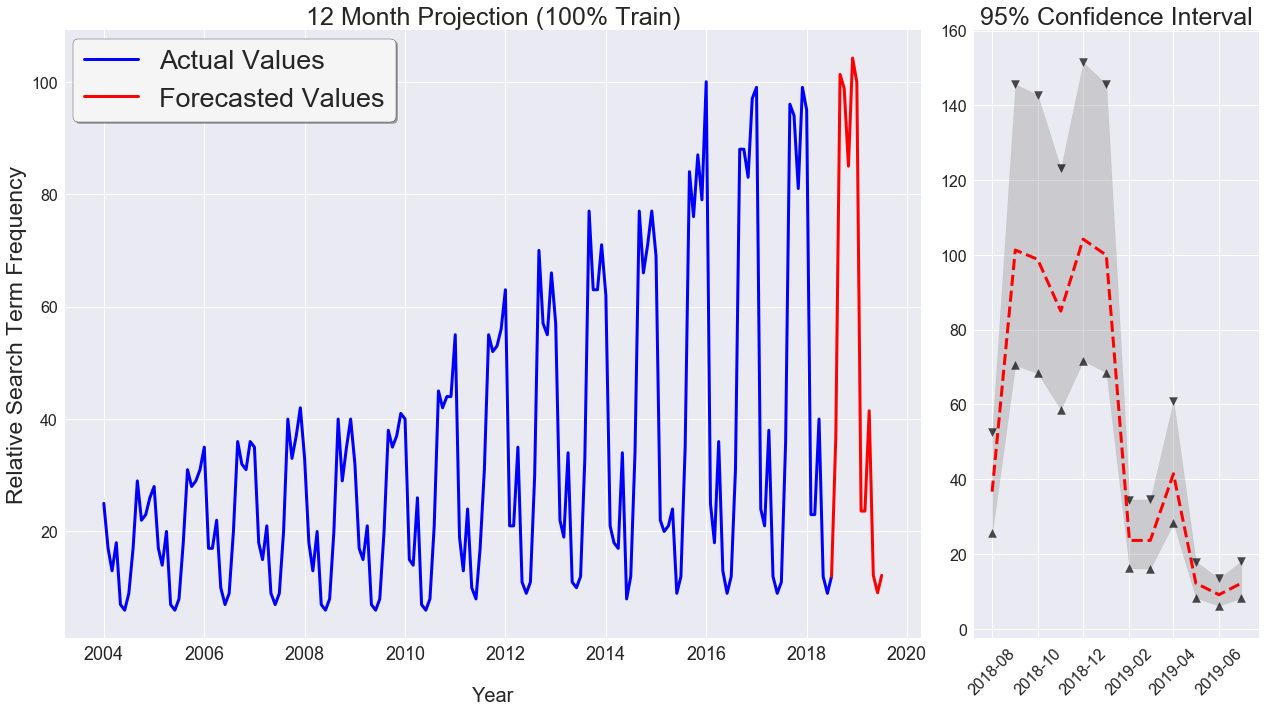

In [36]:
#Instantiating and fitting the model
model = SARIMAX(logged_df.NFL, order=(2, 1, 2), seasonal_order=(1, 0, 0, 12), enforce_stationarity=False,
               enforce_invertibility=False)

model_fit = model.fit(disp=False)

#Forecasting the model
forecast = model_fit.forecast(12)
forecast = np.exp(forecast)

#Finding the forecast confidence interval
predict = model_fit.get_prediction(end=model.nobs+11)
idx = predict.predicted_mean.index
predict_ci = predict.conf_int(alpha=.05)

#Forecasting from the last fitted model point (visual purposes)
tstamp = df.NFL.index[-1]
tvalue = df.NFL[-1]
first_val = pd.Series(tvalue, index=[tstamp])
forecast = pd.concat([first_val, forecast])

#Past data and forecast plot
fig, ax = plt.subplots(figsize=(18, 10))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
ax0 = plt.subplot(gs[0])
ax0.plot(df.NFL, 'b', lw=3)
ax0.plot(forecast, 'r', lw=3)
ax0.set_title('12 Month Projection (100% Train)', size=25)

#C.I. Plot
ax1 = plt.subplot(gs[1])
ax1.plot(forecast[1:], 'r', lw=3, linestyle='--')
ax1.fill_between(idx[-12:], np.exp(predict_ci.iloc[:, 0][-12:]), np.exp(predict_ci.iloc[:, 1][-12:]), alpha=.3, color='grey')
ax1.scatter(x=idx[-12:],y=np.exp(predict_ci.iloc[:, 0][-12:]), color='k', s=65, alpha=.7, marker='^')
ax1.scatter(x=idx[-12:],y=np.exp(predict_ci.iloc[:, 1][-12:]), color='k', s=65, alpha=.7, marker='v')
ax1.set_title('95% Confidence Interval', size=25)

#Setting tick size for plot 1
[xtick.set_fontsize(18) for xtick in ax0.get_xticklabels()]
[ytick.set_fontsize(16) for ytick in ax0.get_yticklabels()]

#Setting tick size and rotation for plot 2
[xtick.set_fontsize(16) for xtick in ax1.get_xticklabels()]
[xtick.set_rotation(45) for xtick in ax1.get_xticklabels()]
[ytick.set_fontsize(16) for ytick in ax1.get_yticklabels()]

#Setting x and y labels
ax0.set_ylabel('Relative Search Term Frequency', size=23)
ax0.set_xlabel('Year', size=20, labelpad=23)

#Custom Legend
custom_lines = [Line2D([0], [0], color='blue', lw=3),
                Line2D([0], [0], color='red', lw=3)]

ax0.legend(custom_lines, ['Actual Values', 'Forecasted Values'], 
          loc=2, prop={'size':27}, fancybox=True, frameon=True,
          shadow=True, facecolor='whitesmoke', edgecolor='k',
          framealpha=1, borderaxespad=.3)

fig.tight_layout();

**Note** As you can see, it is very important to evaluate time series forecasting with different amounts of training data. 

# Final Forecasts

To predict the next 18 months, we need to look at the ACF and PACF plots for each search term individually. p, q, and S parameters for each will be stored in dictionaries to be used in a later forecasting function.

### ACF + PACF

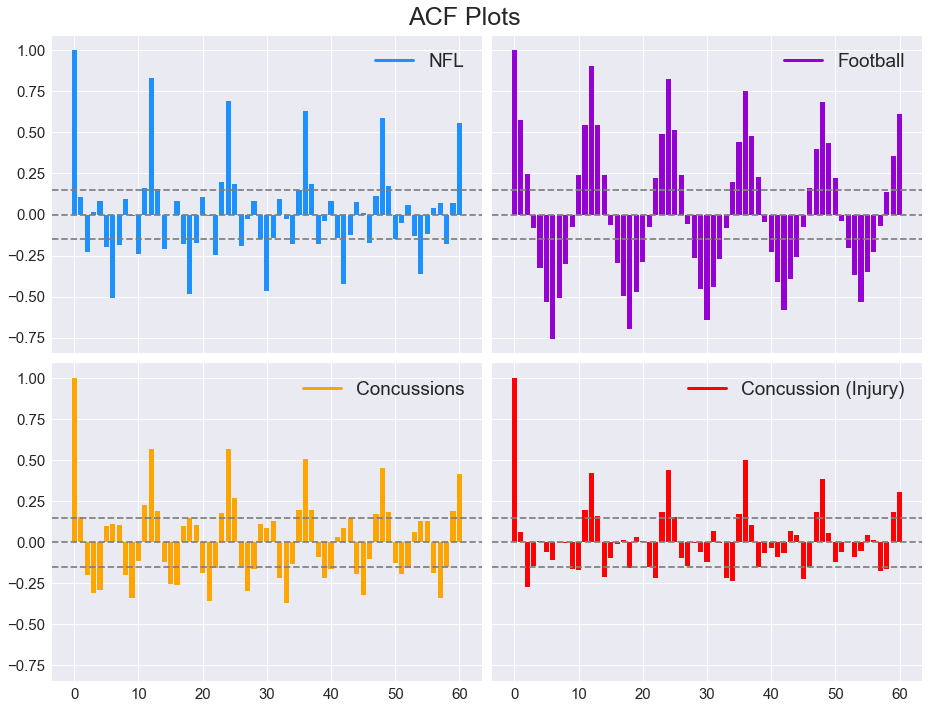

In [61]:
#Instantiating the plot
fig, axarr = plt.subplots(ncols=2, nrows=2, figsize=(13, 10), sharey=True, sharex=True)

#Plotting the 4 differenced terms
for col, axs in zip(logged_df.columns, axarr.flatten()):
    lag_acf = acf(log_diff_df[col].dropna(), nlags=60)
    axs.bar(np.arange(61), lag_acf, color = color_dict[col])
    axs.axhline(y=0, linestyle='--', color='grey')
    axs.axhline(y=1.96/np.sqrt(len(log_diff_df[col].dropna())), linestyle='--', color='grey')
    axs.axhline(y=-1.96/np.sqrt(len(log_diff_df[col].dropna())), linestyle='--', color='grey')
    axs.legend([Line2D([0], [0], color=color_dict[col], lw=3)],[col], prop={'size':19}, loc=1)
    axs.tick_params(labelsize=15)

fig.tight_layout()
fig.suptitle('ACF Plots', size=25)
fig.subplots_adjust(top=.94)

q values for each term...
1. NFL: q = 2
2. Football: q = 1
3. Concussions: q = 1
4. Concussion (Injury): q = 2

In [38]:
q_dict = dict({'NFL': 2, 'Football': 1, 'Concussions': 1, 'Concussion (Injury)': 2})
#Concussion and Concussion (Injury) show stability in their seasonal pattern (judgement call)
S_dict = dict({'NFL': 0, 'Football': 0, 'Concussions': 1, 'Concussion (Injury)': 1})

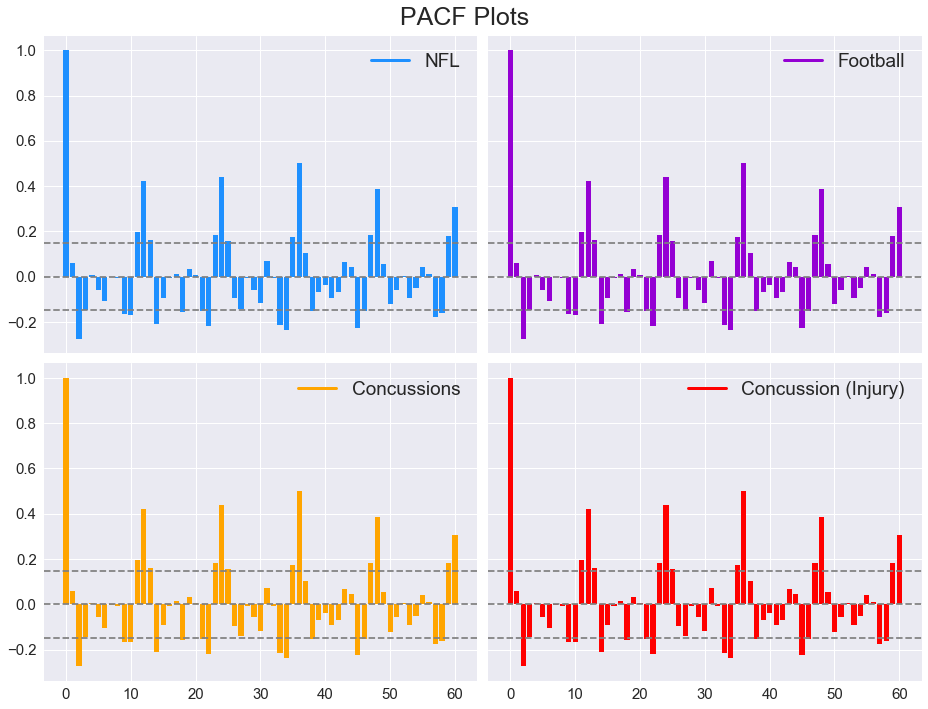

In [62]:
#Instantiating the plot
fig, axarr = plt.subplots(ncols=2, nrows=2, figsize=(13, 10), sharey=True, sharex=True)

#Plotting the 4 differenced terms
for col, axs in zip(logged_df.columns, axarr.flatten()):
    lag_pacf = pacf(log_diff_df[col].dropna(), nlags=60, method='ols')
    axs.bar(np.arange(61), lag_acf, color = color_dict[col])
    axs.axhline(y=0, linestyle='--', color='grey')
    axs.axhline(y=1.96/np.sqrt(len(log_diff_df[col].dropna())), linestyle='--', color='grey')
    axs.axhline(y=-1.96/np.sqrt(len(log_diff_df[col].dropna())), linestyle='--', color='grey')
    axs.legend([Line2D([0], [0], color=color_dict[col], lw=3)],[col], prop={'size':19}, loc=1)
    axs.tick_params(labelsize=15)


fig.tight_layout()
fig.suptitle('PACF Plots', size=25)
fig.subplots_adjust(top=.94)

p values for each term...
1. NFL: p = 2
2. Football: p = 2
3. Concussions: p = 2
4. Concussion (Injury): p = 2

In [40]:
p_dict = dict({'NFL': 2, 'Football': 2, 'Concussions': 2, 'Concussion (Injury)': 2})

# 18 Month Plots

In [41]:
def four_forecasts(proportion_train, og_data, logged_df, col, p_dict, q_dict, S_dict):
    """Helper function to output a forecast using a specified proportion of training data. It also 
    uses specific parameters for the SARIMAX function unique to the input variable."""
    
    #Train and Test data
    split_idx = round(logged_df.shape[0] * proportion_train)
    train = logged_df[:split_idx]
    test = logged_df[split_idx:]
    
    #Instantiating and fitting the model    
    model = SARIMAX(train[col], order=(p_dict[col], 1, q_dict[col]), seasonal_order=(1, S_dict[col], 0, 12), enforce_stationarity=False,
                   enforce_invertibility=False)

    model_fit = model.fit(disp=False)

    #Forecasting the model
    forecast = model_fit.forecast(test.shape[0]+18)
    forecast = np.exp(forecast)
    forecast = forecast[-18:]

    #Forecasting from the last fitted model point (visual purposes)
    tstamp = og_data[col].index[-1]
    tvalue = og_data[col][-1]
    first_val = pd.Series(tvalue, index=[tstamp])
    forecast = pd.concat([first_val, forecast])

    return(forecast)

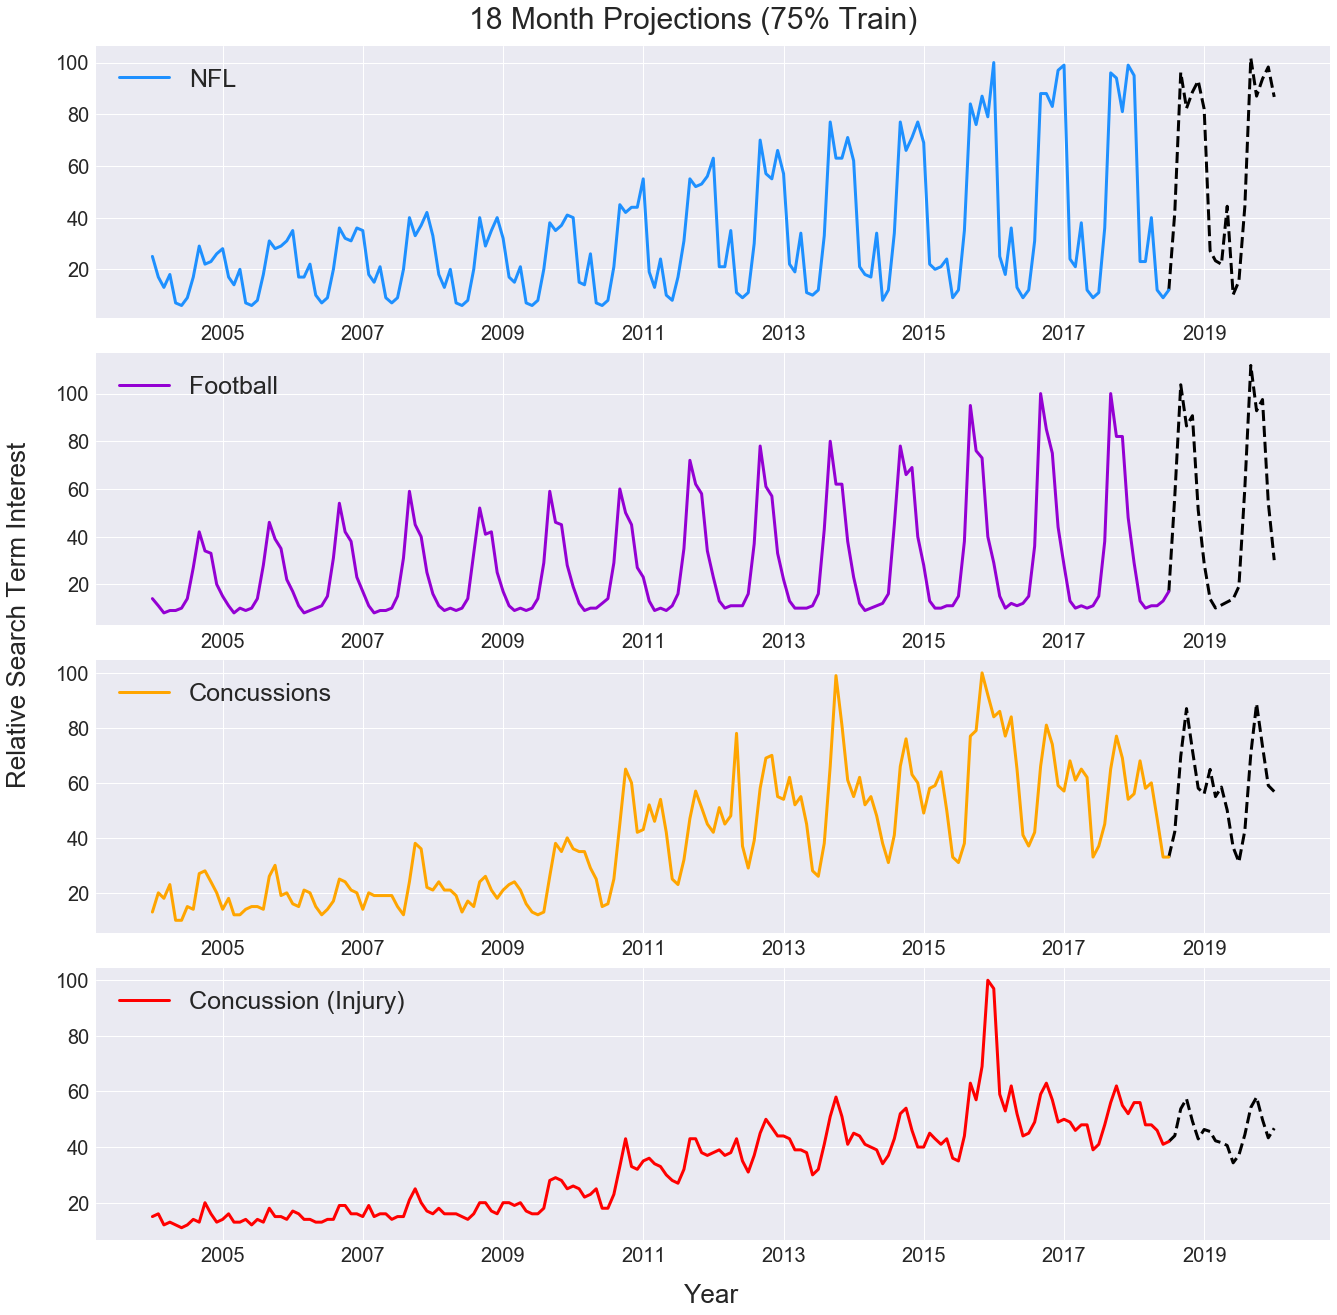

In [42]:
#Instantiating the plot
fig, axarr = plt.subplots(ncols=1, nrows=4, figsize=(18, 18))

#Plotting the 4 differenced terms
for col, axs in zip(logged_df.columns, axarr.flatten()):
    forecast = four_forecasts(.75, df, logged_df, col, p_dict, q_dict, S_dict)
    axs.plot(forecast, linewidth=3, color='black', linestyle='--')
    axs.plot(df[col], linewidth=3, color=color_dict[col])
    [ytick.set_fontsize(20) for ytick in axs.get_yticklabels()]
    [xtick.set_fontsize(20) for xtick in axs.get_xticklabels()]

#Setting legends
[ax.legend(prop={'size':25}, loc=2) for ax in axarr.flatten()]    

#Labels and layout
fig.suptitle('18 Month Projections (75% Train)', size=30)
fig.tight_layout()
fig.subplots_adjust(top=.95)
fig.text(-0.02, .63, 'Relative Search Term Interest', size=26, ha='center', rotation='vertical')
fig.text(.514, -0.02, 'Year', size=26, ha='center');

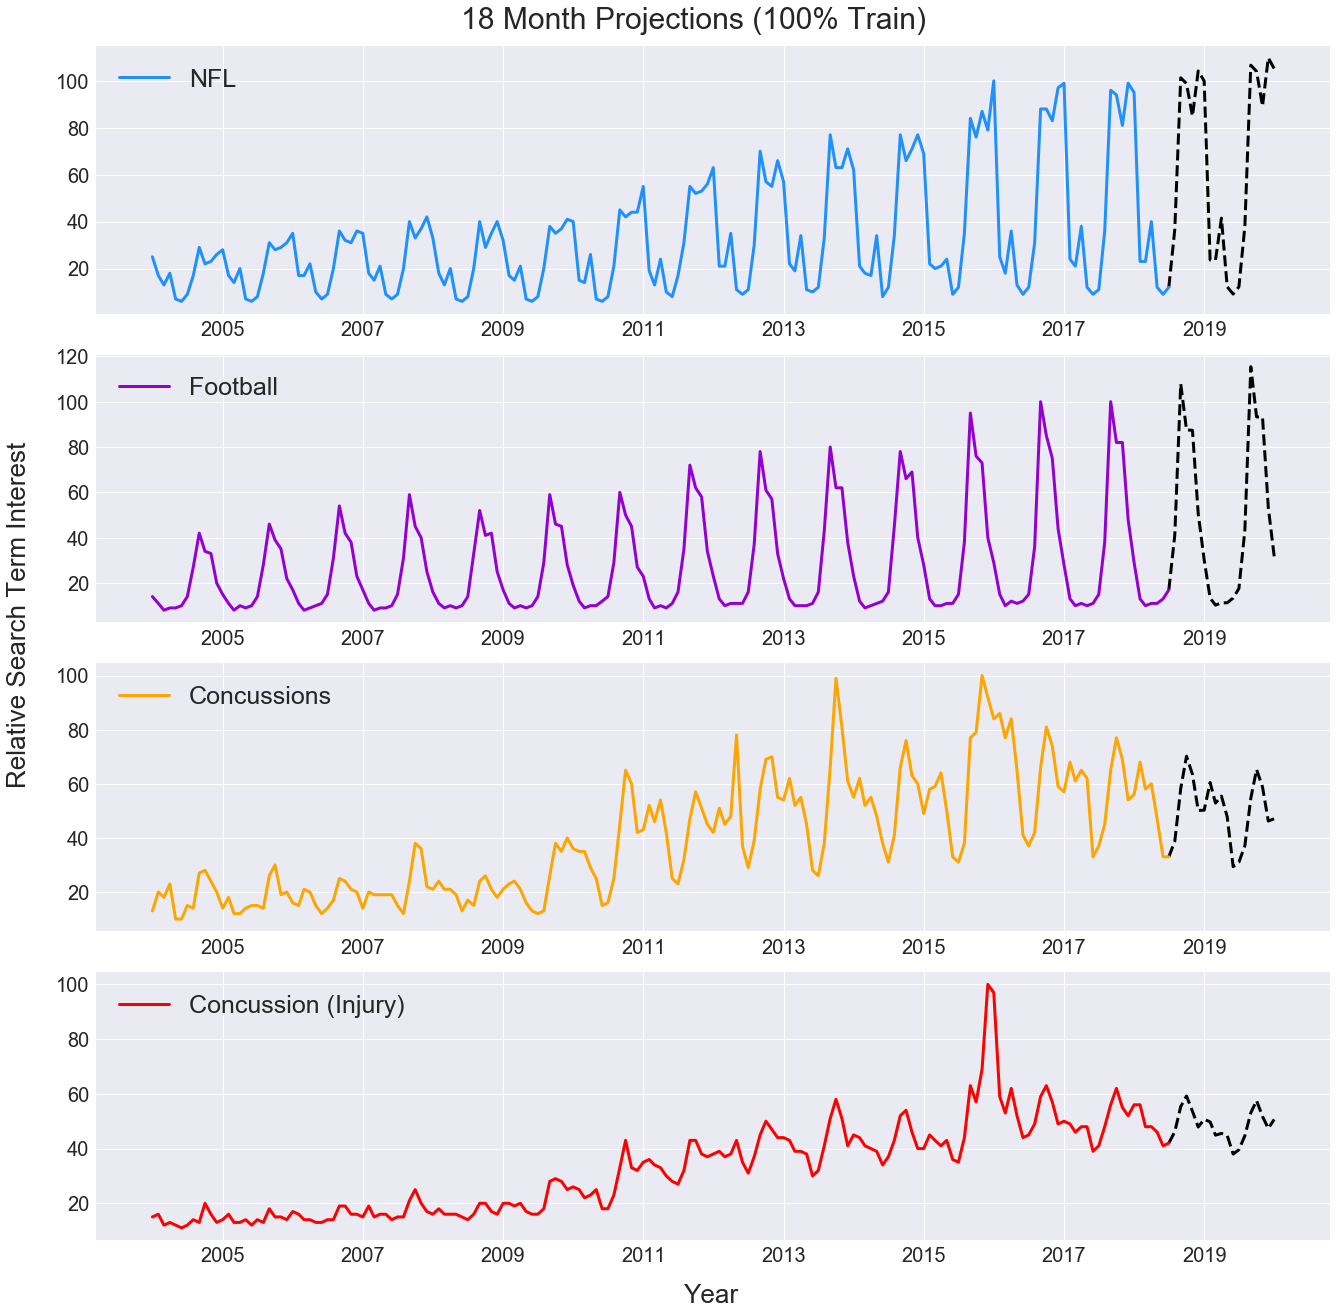

In [43]:
#Instantiating the plot
fig, axarr = plt.subplots(ncols=1, nrows=4, figsize=(18, 18))

#Plotting the 4 differenced terms
for col, axs in zip(logged_df.columns, axarr.flatten()):
    forecast = four_forecasts(1, df, logged_df, col, p_dict, q_dict, S_dict)
    axs.plot(forecast, linewidth=3, color='black', linestyle='--')
    axs.plot(df[col], linewidth=3, color=color_dict[col])
    [ytick.set_fontsize(20) for ytick in axs.get_yticklabels()]
    [xtick.set_fontsize(20) for xtick in axs.get_xticklabels()]

#Setting legends
[ax.legend(prop={'size':25}, loc=2) for ax in axarr.flatten()]    

#Labels and layout
fig.suptitle('18 Month Projections (100% Train)', size=30)
fig.tight_layout()
fig.subplots_adjust(top=.95)
fig.text(-0.02, .63, 'Relative Search Term Interest', size=26, ha='center', rotation='vertical')
fig.text(.514, -0.02, 'Year', size=26, ha='center');

And there we have it, forecasts complete!

# Conclusion

At the start of this report, we set out to find the correlations for "NFL" and "Football" to "Concussions" and "Concussion (Injury)". To account for possible significant lags, we shifted the concussion categories by 1, 0, and -1. We found that overall, "NFL" more strongly correlates to both concussion terms. However when we removed the growth trend, we found that the seasonal patterns are almost eqully correlated, except for the non-lagged "Concussions" term where "Football" is double "NFL". 

Satisfied with our result, we moved on to forecasting the next 18 months of relative search term interest for each term. Using ACF and PACF plots, we found ideal terms for both the seasonal and non-seasonal components. These components are the autoregressive (AR: q), difference (d), and moving average (MA: p) terms (see reference). Building SARIMA models, we evaluated the success of our component selection with grid search and root mean squared error. 95% confidence interval plots allowed us to see the impact the amount of training data has on prediction uncertainty. Lastly, we plotted 18 month forecasts for each search term for 75% training data 100% training data. These forecasts look reasonable, come back in January 2020 to see how accurate they ended up being!

# Extra Observation:

In case you have some experience with time series, you might know that there is an alternative way to remove a long term trend from data. Rather than use first-order differencing, you could subtract the rolling average from the data instead. An example of this is provided below.

### Rolling Average Subtraction (Alternative to First-Order Differencing)

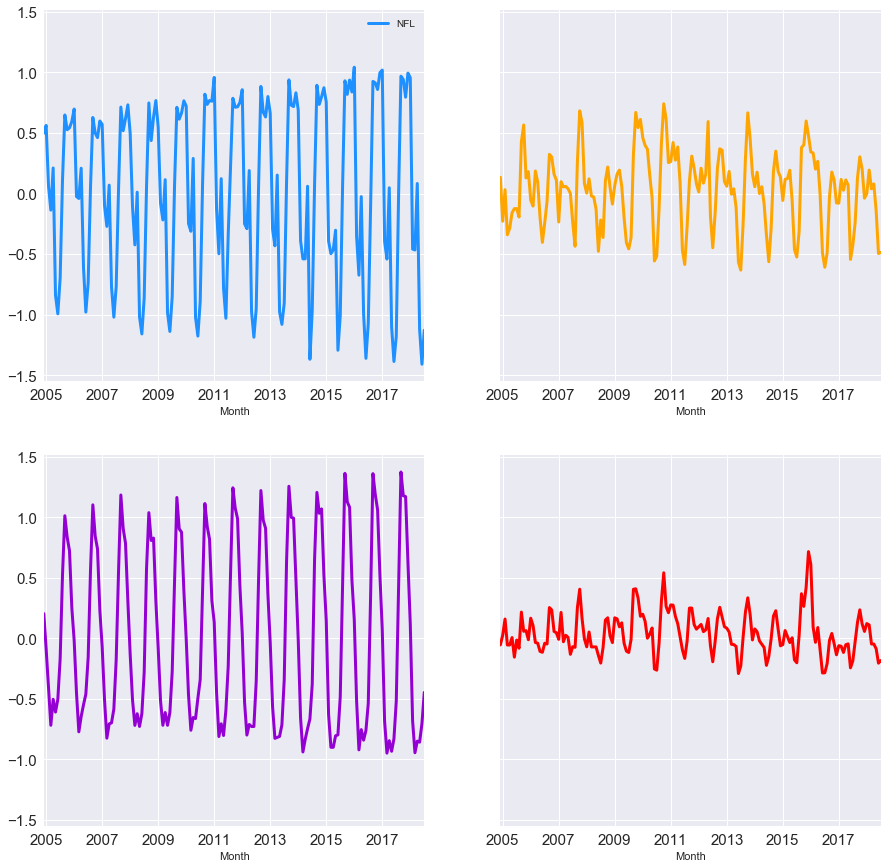

In [47]:
roll_mean = (np.log(df) - np.log(df).rolling(12).mean()).dropna()

fig, axarr = plt.subplots(ncols=2, nrows=2, figsize=(18, 10), sharey=True)

roll_mean[['NFL']].plot(figsize=(15, 15), fontsize=15, linewidth=3, ax=axarr[0, 0], color='dodgerblue')
roll_mean['Football'].plot(figsize=(15, 15), fontsize=15, linewidth=3, ax=axarr[1, 0], color='darkviolet')
roll_mean['Concussions'].plot(figsize=(15, 15), fontsize=15, linewidth=3, ax=axarr[0, 1], color='orange')
roll_mean['Concussion (Injury)'].plot(figsize=(15, 15), fontsize=15, linewidth=3, ax=axarr[1, 1], color='red');